# RNN for Stock Returns

download starbucks stocks file from: https://github.com/xscotophilic/Learning-Tensorflow/files/6488775/starbucks.csv

Importing the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

## ::::: Section 1 Importing and preprocessing data :::::

The **high** and **low** prices in stock trading refer to the highest and lowest prices in a given time period.

The **open** and **close** prices of a stock are the prices at which it began and ended trading in the same period.

**Volume** is the total number of shares traded in a security over a period.

### -x- Importing csv and inspecting it. -x-

In [ ]:
dataframe = pd.read_csv('starbucks.csv')

print("Inspecting the data of csv file.")
print()
print(dataframe.head())
print()
print(dataframe.tail())

Inspecting the data of csv file.

         date    open    high     low   close   volume  Name
0  2013-02-08  27.920  28.325  27.920  28.185  7146296  SBUX
1  2013-02-11  28.260  28.260  27.930  28.070  5457354  SBUX
2  2013-02-12  28.000  28.275  27.975  28.130  8665592  SBUX
3  2013-02-13  28.230  28.230  27.750  27.915  7022056  SBUX
4  2013-02-14  27.765  27.905  27.675  27.775  8899188  SBUX

            date    open   high    low  close    volume  Name
1254  2018-02-01  56.280  56.42  55.89  56.00  14690146  SBUX
1255  2018-02-02  55.900  56.32  55.70  55.77  15358909  SBUX
1256  2018-02-05  55.530  56.26  54.57  54.69  16059955  SBUX
1257  2018-02-06  53.685  56.06  53.56  55.61  17415065  SBUX
1258  2018-02-07  55.080  55.43  54.44  54.46  13927022  SBUX


## ::::: Section 2 What not to start with? :::::

What we should not do is predict the price of the stock itself (which means predicting the close price); it is a terrible place to start learning.

In [ ]:
series = dataframe['close'].values.reshape(-1, 1)

### -x- Preprocessing data. -x-

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalizing the data
# Note: I didn't think about where the true boundary is, this is just approx.
sc = StandardScaler()
sc.fit(series[:len(series) // 2])
series = sc.transform(series).flatten()

### -x- Building the dataset -x-
Creating a series of T previous values to predict the next value and dividing them into x and y.

In [ ]:
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


### -x- Trying autoregressive RNN model -x-

#### -o- Training the model -o-

In [ ]:
input = tf.keras.layers.Input(shape=(T, 1))
x = tf.keras.layers.LSTM(5)(input)
x = tf.keras.layers.Dense(1)(x)

model = tf.keras.models.Model(input, x)
model.compile(
  loss='mse',
  optimizer=tf.keras.optimizers.Adam(lr=0.1),
)

# training the RNN
history = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 2s 41ms/step - loss: 0.3679 - val_loss: 0.2625
Epoch 2/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0188 - val_loss: 0.0285
Epoch 3/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0127 - val_loss: 0.0239
Epoch 4/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0219
Epoch 5/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0485
Epoch 6/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0081 - val_loss: 0.0305
Epoch 7/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0360
Epoch 8/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0065 - val_loss: 0.0333
Epoch 9/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0293
Epoch 10/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.0369
Epoch 11/80
20/20 

#### -o- Plotting loss per iteration -o-


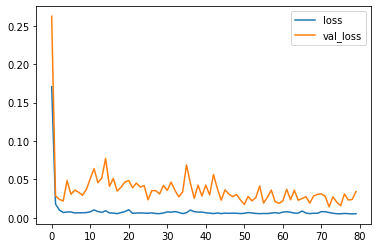

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

#### -o- One-step forecast using true targets -o-


(1249, 1)


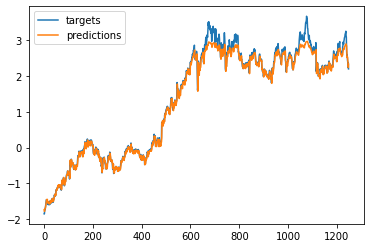

In [ ]:
outputs = model.predict(X)
print(outputs.shape)

predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

#### -o- Multi-step forecast -o-

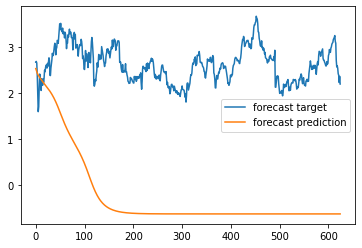

In [ ]:
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

## ::::: Section 3 What to predict if not price of the stock itself? :::::

When it comes to modelling a stock market, the most important object we can model is the return rather than the price.

If we consider a particular day n and its previous day n-1 the return is calculated as:

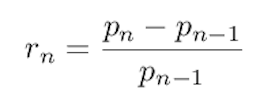

### -x- Aligning particular day n and its previous day n-1's data -x-

In [ ]:
# calculate returns by first shifting the data
dataframe['PrevClose'] = dataframe['close'].shift(1)

# so now it's like
# close / prev close (eg. yesterday's closing price will be aligned with today's closing price)

# x[-2] (day before yesterday's closing)      x[-1] (yesterday's closing)
# x[-1] (yesterday's closing)                 x[0] (today's closing)
# x[0] (today's closing)                      x[1] (tomorrow's closing)
# ...                                         ...
# x[t]                                        x[t-1]

### -x- Inspecting the dataframe (aligned particular day n and its previous day n-1's data) -x-

In [ ]:
print("Inspecting the dataframe.")
print()
print(dataframe.head())

Inspecting the dataframe.

         date    open    high     low   close   volume  Name  PrevClose
0  2013-02-08  27.920  28.325  27.920  28.185  7146296  SBUX        NaN
1  2013-02-11  28.260  28.260  27.930  28.070  5457354  SBUX     28.185
2  2013-02-12  28.000  28.275  27.975  28.130  8665592  SBUX     28.070
3  2013-02-13  28.230  28.230  27.750  27.915  7022056  SBUX     28.130
4  2013-02-14  27.765  27.905  27.675  27.775  8899188  SBUX     27.915


### -x- Calculating the returns -x-

In [ ]:
dataframe['Return'] = (dataframe['close'] - dataframe['PrevClose']) / dataframe['PrevClose']

### -x- Inspecting the dataframe (Returns) -x-

In [ ]:
print("Inspecting the dataframe.")
print()
print(dataframe.head())

Inspecting the dataframe.

         date    open    high     low  ...   volume  Name PrevClose    Return
0  2013-02-08  27.920  28.325  27.920  ...  7146296  SBUX       NaN       NaN
1  2013-02-11  28.260  28.260  27.930  ...  5457354  SBUX    28.185 -0.004080
2  2013-02-12  28.000  28.275  27.975  ...  8665592  SBUX    28.070  0.002138
3  2013-02-13  28.230  28.230  27.750  ...  7022056  SBUX    28.130 -0.007643
4  2013-02-14  27.765  27.905  27.675  ...  8899188  SBUX    27.915 -0.005015

[5 rows x 9 columns]


### -x- Plotting the histogram of return -x-

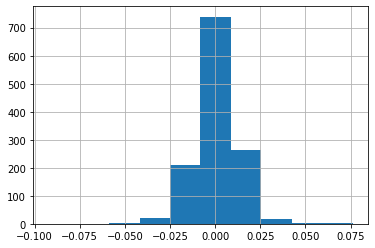

In [ ]:
dataframe['Return'].hist()

### -x- Applying scalar and flattening data -x-

In [ ]:
series = dataframe['Return'].values[1:].reshape(-1, 1)

# Normalizing the data
# Note: I didn't think about where the true boundary is, this is just approx.
sc = StandardScaler()
sc.fit(series[:len(series) // 2])
series = sc.transform(series).flatten()

### -x- Building the dataset -x-
Creating a series of T previous values to predict the next value and dividing them into x and y.

In [ ]:
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


### -x- Trying autoregressive RNN model -x-

#### -o- Training the model -o-

In [ ]:
input = tf.keras.layers.Input(shape=(T, 1))
x = tf.keras.layers.LSTM(5)(input)
x = tf.keras.layers.Dense(1)(x)

model = tf.keras.models.Model(input, x)
model.compile(
  loss='mse',
  optimizer=tf.keras.optimizers.Adam(lr=0.01),
)

# training the RNN
history = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 2s 25ms/step - loss: 1.0496 - val_loss: 1.1452
Epoch 2/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9861 - val_loss: 1.1448
Epoch 3/80
20/20 [==============================] - 0s 8ms/step - loss: 0.8919 - val_loss: 1.1492
Epoch 4/80
20/20 [==============================] - 0s 7ms/step - loss: 1.0798 - val_loss: 1.1414
Epoch 5/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9692 - val_loss: 1.1486
Epoch 6/80
20/20 [==============================] - 0s 7ms/step - loss: 0.8767 - val_loss: 1.1493
Epoch 7/80
20/20 [==============================] - 0s 7ms/step - loss: 0.8656 - val_loss: 1.1454
Epoch 8/80
20/20 [==============================] - 0s 8ms/step - loss: 1.0272 - val_loss: 1.1452
Epoch 9/80
20/20 [==============================] - 0s 7ms/step - loss: 1.0751 - val_loss: 1.1457
Epoch 10/80
20/20 [==============================] - 0s 8ms/step - loss: 0.8991 - val_loss: 1.1500
Epoch 11/80
20/20 

#### -o- Plotting loss per iteration -o-


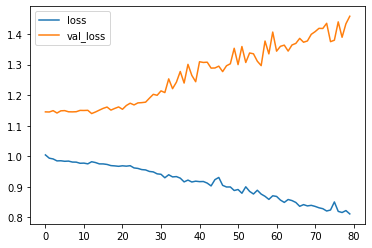

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

#### -o- One-step forecast using true targets -o-


(1248, 1)


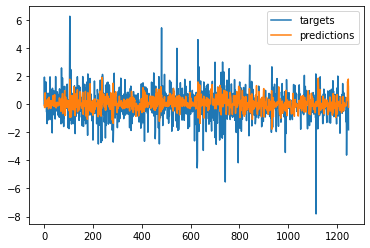

In [ ]:
outputs = model.predict(X)
print(outputs.shape)

predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

#### -o- Multi-step forecast -o-

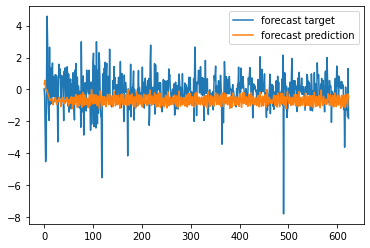

In [ ]:
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

## ::::: Section 4 Using open, high, low, close, volume for prediction :::::

Now, simply predicting if price will go up or down (Binary Classification).

### -x- Converting data into numpy arrays. -x-

In [ ]:
# Not yet in the final "X" format!
input_data = dataframe[['open', 'high', 'low', 'close', 'volume']].values
targets = dataframe['Return'].values

### -x- N x T x D shape -x-

In [ ]:
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]

### -x- Applying scalar -x-

In [ ]:
Ntrain = len(input_data) * 2 // 3

sc = StandardScaler()
sc.fit(input_data[:Ntrain + T - 1])
input_data = sc.transform(input_data)

### -x- Setting up X_train and Y_train -x-

In [ ]:
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

### -x- Setting up X_test and Y_test -x-

In [ ]:
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

### -x- Trying RNN model -x-

#### -o- Compiling the model -o-

In [ ]:
input = tf.keras.layers.Input(shape=(T, D))
x = tf.keras.layers.LSTM(50)(input)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(input, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=tf.keras.optimizers.Adam(lr=0.001),
  metrics=['accuracy'],
)

#### -o- Training the RNN -o-

In [ ]:
history = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 2s 24ms/step - loss: 0.6990 - accuracy: 0.4496 - val_loss: 0.6940 - val_accuracy: 0.4854
Epoch 2/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.5111 - val_loss: 0.6948 - val_accuracy: 0.4854
Epoch 3/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.4952 - val_loss: 0.6925 - val_accuracy: 0.5244
Epoch 4/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6941 - accuracy: 0.5288 - val_loss: 0.6924 - val_accuracy: 0.5171
Epoch 5/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6878 - accuracy: 0.5447 - val_loss: 0.6940 - val_accuracy: 0.4951
Epoch 6/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6910 - accuracy: 0.5069 - val_loss: 0.6930 - val_accuracy: 0.4805
Epoch 7/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6908 - accuracy: 0.5156 - val_loss: 0.6937 - val_accuracy: 0.4951
Epoch 8/300


#### -o- Plotting loss per iteration -o-


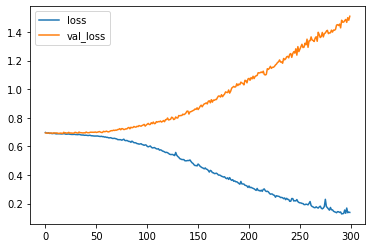

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

#### -o- Plotting loss per iteration -o-


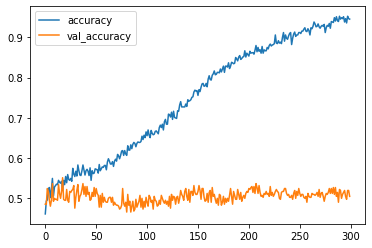

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## In some cases, it may be possible to predict stock returns, but for given data, it is extremely difficult to train any model that fits nicely. As you can see, we tried three models, all of which performed dismally, and Section 2 only appears to work okaish.